---
# Optional: 
---

- bla bla 
- bla

#### Setup of your Python kernel
Let's load our standard library functions, and setup matplotlib for nice inline plots

In [4]:
# Import custom tracking functions and useful libraries
from tracking_library import *

# Set up plotting
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

---

## Ellipses ans Single Particle Emittance

It turns out that our particle turn-after-turn stays on an ellipses: 

\begin{equation}
\epsilon = \gamma x^2 + 2 \alpha x x' + \beta x{'\,}^2
\end{equation}

where $(\alpha, \beta, \gamma)$ are the periodic Twiss parameter! and $\epsilon$, in this case, is the **single particle emittance**.

Without entering in the implementation details, two useful functions are defined in our library toolbox: 
- one that can give us the single particle emittance: `particle_emittance(x, xp, beta, alpha)`
- one to give us the coordinate in phase space for an ellipse with the given Twiss and emittance: `ellipse_points(emittance, beta, alpha, n_points = 100)`

In [2]:
from tracking_library import particle_emittance
from tracking_library import ellipse_points

help(particle_emittance)
help(ellipse_points)

Help on function particle_emittance in module tracking_library:

particle_emittance(x, xp, beta, alpha)
    Returns the single particle emittance for a given 
    x, xp particle coordinates and assumed beta and alpha parameters

Help on function ellipse_points in module tracking_library:

ellipse_points(emittance, beta, alpha, n_points=100)
    Returns the x,x' coordinates of an ellipse in phase space for 
    the given Twiss parameters (beta, gamma, emittance)



### Exercise 25

Consider the usual FODO cell, repeated 100 times.
Plot the trajectory, in phase space, of a particle with x=1 mm and xp=0 cell after cell.

Using the functions you have now available, compute the expected periodic solution of our cell, and use this information to:

- compute the single particle emittance
- produce the coordinates in phase space of an ellipse with such an emittance

Plot both the tracked particle coordinates and the ellipse in phase space: what do you observe?

**Optional:** would you be able to predict the exact tracked particle coordinates only from the single cell?

**Hint:** for this last question, one needs to look carefully at the functions implementation details...


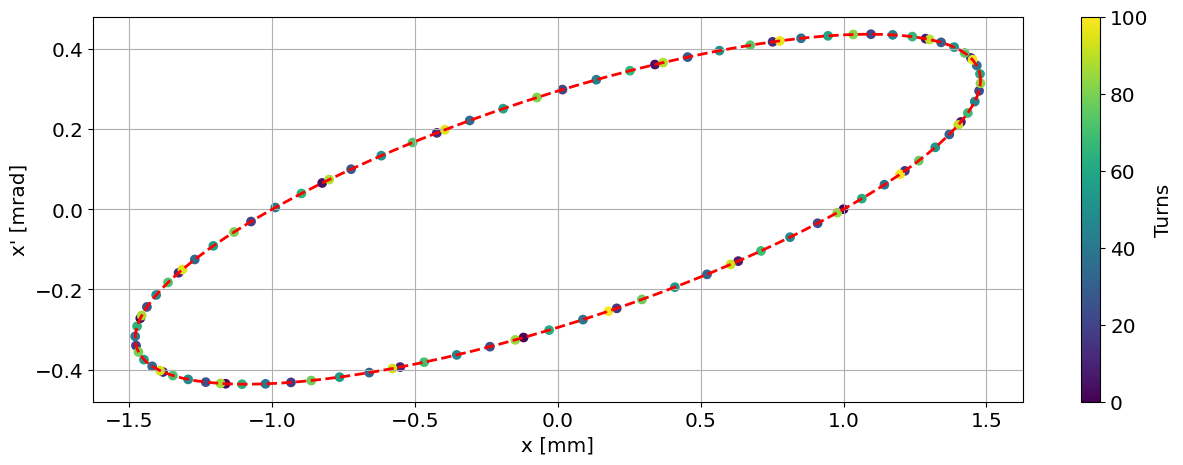

In [5]:
# define our usual FODO cell
f = 2.5
L = 2
fodo_lattice = 5*D(L/10) + Q(f) + 10*D(L/10) + Q(-f) + 5*D(L/10)

# compute the periodic solution
tune, beta, alpha, gamma = twiss(fodo_lattice)

# generate a particle
x = 1
xp = 0
particle = [[x],[xp]]

# compute the associate single-particle emittance of this particle
single_part_emit = particle_emittance(x, xp, beta, alpha)
# get coordinate of an ellipse in phase space with the given parameters
ellipse_coordinates = ellipse_points(single_part_emit, beta, alpha)

# track the particle over 100 cells
OTM = getEquivalentElement(fodo_lattice)
transported_particles = transportParticles(particle,100*OTM)

# plot tracked particles as well as ellipse
plt.plot(ellipse_coordinates[0,:], ellipse_coordinates[1,:],'r--', lw=2)
plt.scatter(transported_particles['x'], transported_particles['xp'], c = transported_particles['s']/(L*2))
cb=plt.colorbar()
cb.set_label('Turns')
plt.xlabel('x [mm]')
plt.ylabel("x' [mrad]")
plt.grid(True)
    


### Exercise 433434

Consider a Toy Machine, made of 8 identical FODO cells (e.g. our values of $f = 2.5$ m and $L = 1$ m).

1. Compute the Tune of the machine and plot the beta function.
2. Assuming this must be a ring, introduce sector bends to make an actual ring (i.e. 360 deg total bending angle). Insert the bends in the middle of all drifts of the FODO cells. How does the optics change?

**Hint:** Our toolbox library implements also sector bends: `B(phi, L)` defined by bending angle (`phi`) and bend lenght (`L`).

Text(0, 0.5, '$\\beta_x\\ [m]$')

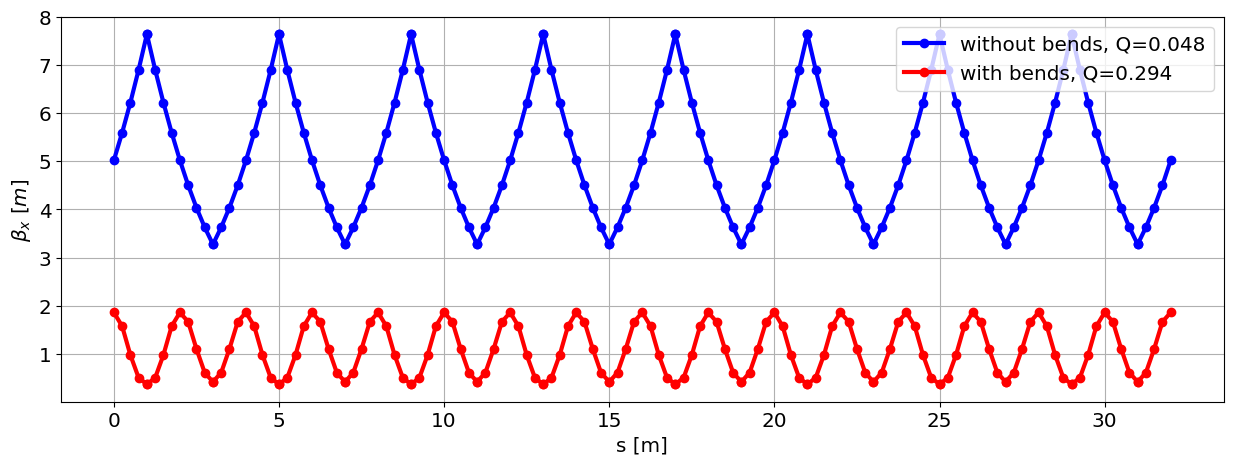

In [10]:
from tracking_library import B

# build up beamline
n_cells = 8
bend_angle = 2*np.pi/n_cells/2
f = 2.5
L = 2

# without bends
fodo_cell = 4*D(L/8) + Q(f) + 8*D(L/8) + Q(-f) + 4*D(L/8) 
beamline = n_cells*fodo_cell
# with bends
fodo_cell_bend = 2*B(bend_angle, L/8) + 2*D(L/8) + Q(f) + 2*D(L/8) +4*B(bend_angle, L/8) + 2*D(L/8) + Q(-f) + 2*D(L/8) + 2*B(bend_angle, L/8)
beamline_bend = n_cells*fodo_cell_bend

# compute twiss without bends
(tune, beta, alpha, gamma) = twiss(beamline)
sigma_0 = np.array([[beta, -alpha],[-alpha, gamma]])
transported_sigmas = transportSigmas(sigma_0, beamline)

# compute twiss with bends
(tune_bend, beta_bend, alpha_bend, gamma_bend) = twiss(beamline_bend)
sigma_0_bend = np.array([[beta_bend, -alpha_bend],[-alpha_bend, gamma_bend]])
transported_sigmas_bend = transportSigmas(sigma_0_bend, beamline_bend)

# plot
plt.plot(transported_sigmas['s'],  transported_sigmas['sigma11'], 'o-b', lw=3, label=f'without bends, Q={tune:.3f}') 
plt.plot(transported_sigmas_bend['s'],  transported_sigmas_bend['sigma11'], 'o-r', lw=3, label=f'with bends, Q={tune_bend:.3f}')
    
plt.grid(True)
plt.legend(loc='best')
plt.xlabel('s [m]')
plt.ylabel('$\\beta_x\ [m]$')